In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap

def modified_coolwarm_low(low="#1a9850", *, N=256, name="coolgreen"):
    """
    Return a version of 'coolwarm' where the *lower* half fades
    into `low` (instead of blue).

    Parameters
    ----------
    low : str or tuple
        Target low-end colour (e.g. "#1a9850" for green).
    N : int
        Number of discrete samples pulled from the base map (256 by default).
    name : str
        Name given to the resulting colormap object.

    Returns
    -------
    matplotlib.colors.ListedColormap
    """
    base = mpl.cm.get_cmap("coolwarm", N)           # original map, N samples
    colors = base(np.linspace(0, 1, N))             # RGBA array, shape (N,4)
    mid = N // 2                                    # neutral grey index
    lo_rgba = mpl.colors.to_rgba(low)

    # Replace the lower half [0 : mid] with a linear blend: `low` → mid-grey
    t = np.linspace(0, 1, mid + 1)[:, None]         # 0 → 1 from low to centre
    colors[:mid + 1] = (1 - t) * lo_rgba + t * colors[mid]

    return ListedColormap(colors, name=name)

In [3]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import acr
import warnings
import pingouin as pg
from scipy.stats import shapiro, normaltest
import os
from pathlib import Path
import numpy as np
import pingouin as pg

warnings.filterwarnings('ignore')
probe_ord = ['NNXr', 'NNXo']
#hue_ord = [NNXR_GRAY, MAIN_COLOR]
from kdephys.utils.main import td
from cmcrameri import cm as scm

#--------------------------------- Import Publication Functions ---------------------------------#
pub_utils = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/pub_utils.py', 'pub_utils')
from pub_utils import *
data_agg = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/data_agg.py', 'data_agg')
from data_agg import *

#--------------------------------- Plotting Setup ---------------------------------#
import pubplots as pp
plt.rcdefaults()
plt.style.use('default')
style_path = "/Users/driessen2@ad.wisc.edu/kdriessen/acr_dev/acr/src/acr/plot_styles/acrvec_labels.mplstyle"
from cmcrameri import cm as scm

In [4]:
import spikeinterface.widgets as sw

In [5]:
nbroot = os.path.join(PAPER_FIGURE_ROOT, 'response_to_review', 'single_unit_sync')
if not os.path.exists(nbroot):
    os.mkdir(nbroot)

In [6]:
sorting_id = 'ebl_cbl_reb'

In [7]:
MAIN_EXP = 'swisin'
SUBJECT_TYPE = 'halo'
MAIN_COLOR = HALO_GREEN
subjects, exps = get_subject_list(type=SUBJECT_TYPE, exp=MAIN_EXP)

# STTC

In [11]:
uidxs = {}
uidxs['ACR_55'] = {'NNXo': [19]}
df_filts = {}
ans = {}
qms = {}
for subject, exp in zip(subjects, exps):
    print(subject, exp)
    df_raw, qm, an = acr.ms.load_spike_df_with_qm(subject, exp, sorting_id, return_analyzers=True)
    unts = {}
    filt_dfs = []
    qms[subject] = qm
    for probe in ['NNXo', 'NNXr']:
        qm_probe = qm.prb(probe)        
        unts[probe] = acr.ms.select_good_units(qm_probe.to_pandas(), presence_min=0.95, full_mask=False)
        untsin = unts[probe][0]
        if subject in uidxs.keys():
            if probe in uidxs[subject].keys():
                mask = np.isin(untsin, uidxs[subject][probe])
                untsin = untsin[~mask]
        df_probe = df_raw.filter((pl.col('probe') == probe)&(pl.col('unit_id').is_in(untsin)))
        filt_dfs.append(df_probe)
    qms[subject] = qms[subject].with_columns(pl.lit(subject).alias('subject'))
    df = pl.concat(filt_dfs)
    df_filts[subject] = df
    ans[subject] = an

ACR_46 swisin2
ACR_50 swisin2
ACR_51 swisin
ACR_52 swisin2
ACR_53 swisin
ACR_54 swisin2
ACR_55 swisin


In [16]:
df_counts = []
for subject in df_filts.keys():
    dc = df_filts[subject].group_by('probe').agg(pl.col('unit_id').unique().count())
    dc = dc.to_pandas()
    dc['subject'] = subject
    dc['sub_type'] = SUBJECT_TYPE
    df_counts.append(dc)
df_count = pd.concat(df_counts)
df_count.to_parquet(f'{SUBJECT_TYPE}_dfcounts.parquet')

In [17]:
count_dfs = []
for subject in qms.keys():
    cdf = qms[subject].filter(pl.col('presence_ratio')>0.95).group_by('probe').count()
    count_dfs.append(cdf)
counts = pl.concat(count_dfs)
counts.write_parquet(f'counts_{SUBJECT_TYPE}.parquet')

In [18]:
concat_qm = pl.concat([qms[subject] for subject in subjects])
concat_qm.write_parquet(f'all_qm_{SUBJECT_TYPE}.parquet')

In [19]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

# Subject - Level STTC

In [20]:
reb_rels_hom = {}
for subject in spike_trains.keys():
    reb_rels_hom[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom > 0.0
        # where mask is false, set hom to nan
        hom[~mask] = np.nan
        
        eps = 1e-6
        cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
        reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))
        
        reb_rel = reb_mtx - cbl_mtx
        reb_rel[~mask] = np.nan
        reb_rels_hom[subject][probe] = reb_rel
nnxo = np.array([np.nanmean(reb_rels_hom[subject]['NNXo']) for subject in reb_rels_hom.keys()])
nnxr = np.array([np.nanmean(reb_rels_hom[subject]['NNXr']) for subject in reb_rels_hom.keys()])

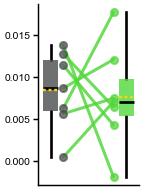

shapiro_p-value: 0.864673355847303
d,agostino_p-value: nan
hedges g: 0.1426199546731206


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.235984,6,two-sided,0.821294,"[-0.01, 0.01]",0.152344,0.362,0.063584


In [21]:
figname = f'{SUBJECT_TYPE}-sttc-homeo-units'
fig_p = f'{figname}.svg'
with pp.destination('figma', style=style_path):
    f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo, colors=[NNXR_GRAY, MAIN_COLOR], fsize=pp.scale(1.15, 1.4))
    ax.set_xticklabels([])
    plt.show()
    f.savefig(os.path.join(nbroot, fig_p), transparent=True, bbox_inches='tight')
diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
agostino_stat, agostino_p = normaltest(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')
print(f'd,agostino_p-value: {agostino_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
# stats = pg.wilcoxon(nnxr, nnxo)
hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))
# ==== Write Stats Results ====
acr.stats.write_stats_result(
    figname, 
    'paired_ttest',
    test_statistic=stats['T'][0],
    p_value=stats['p-val'][0],
    effect_size_method='g',
    effect_size=hg,
    review=True,
)

## ===== Write Source Data =====
source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
write_source_data(source_data, figname)
stats

In [22]:
reb_rels_fixed = {}
for subject in spike_trains.keys():
    reb_rels_fixed[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom <= 0.0
        # where mask is false, set hom to nan
        hom[~mask] = np.nan
        
        eps = 1e-6
        cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
        reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))
        
        reb_rel = reb_mtx - cbl_mtx
        reb_rel[~mask] = np.nan
        reb_rels_fixed[subject][probe] = reb_rel
nnxo = np.array([np.nanmean(reb_rels_fixed[subject]['NNXo']) for subject in reb_rels_fixed.keys()])
nnxr = np.array([np.nanmean(reb_rels_fixed[subject]['NNXr']) for subject in reb_rels_fixed.keys()])

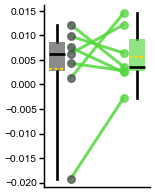

shapiro_p-value: 0.41318240601954564
d,agostino_p-value: nan
hedges g: -0.26843043402586714


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.672985,6,two-sided,0.526014,"[-0.01, 0.01]",0.286733,0.425,0.098774


In [23]:
figname = f'{SUBJECT_TYPE}-sttc-fixed-units'
fig_p = f'{figname}.svg'
with pp.destination('figma', style=style_path):
    f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo, colors=[NNXR_GRAY, MAIN_COLOR], fsize=pp.scale(1.15, 1.4), alphas=[0.65, 0.65])
    ax.set_xticklabels([])
    plt.show()
    f.savefig(os.path.join(nbroot, fig_p), transparent=True, bbox_inches='tight')
diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
agostino_stat, agostino_p = normaltest(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')
print(f'd,agostino_p-value: {agostino_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
# stats = pg.wilcoxon(nnxr, nnxo)
hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))
# ==== Write Stats Results ====
acr.stats.write_stats_result(
    figname, 
    'paired_ttest',
    test_statistic=stats['T'][0],
    p_value=stats['p-val'][0],
    effect_size_method='g',
    effect_size=hg,
    review=True,
)

## ===== Write Source Data =====
source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
write_source_data(source_data, figname)
stats


# Single Unit-Level STTC

In [24]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

In [25]:
# Homeostatically regulated unit pairs
ubu_hom = {}
ubudf_hom = {}
ubudf_hom['NNXo'] = []
ubudf_hom['NNXr'] = []
for subject in spike_trains.keys():
    ubu_hom[subject] = {}
    for probe in ['NNXo', 'NNXr']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom > 0.0
        ebl = sttcs[subject]['early_bl'][probe]
        cbl = sttcs[subject]['circ_bl'][probe]
        reb = sttcs[subject]['rebound'][probe]
        ebl[~mask] = np.nan
        cbl[~mask] = np.nan
        reb[~mask] = np.nan
        cbl_df = acr.stats.get_positions_and_values_df(cbl, 'sttc_late', subject)
        reb_df = acr.stats.get_positions_and_values_df(reb, 'sttc_rebound', subject)
        reb_df = reb_df.merge(cbl_df, on=['mouse', 'unit_i', 'unit_j'], how='inner')
        reb_df['probe'] = probe
        ubudf_hom[probe].append(reb_df)
ubudf_hom['NNXo'] = pd.concat(ubudf_hom['NNXo'])
ubudf_hom['NNXr'] = pd.concat(ubudf_hom['NNXr'])
main_ubudf_hom = pd.concat(ubudf_hom.values())
main_ubudf_hom['probe'] = main_ubudf_hom['probe'].replace({'NNXo': 'optrode', 'NNXr': 'contra'})
dz = acr.stats.fisher_z(main_ubudf_hom["sttc_rebound"].to_numpy()) - acr.stats.fisher_z(main_ubudf_hom["sttc_late"].to_numpy())
main_ubudf_hom["dz"] = dz

In [15]:
out, idata = acr.stats.pooled_dyadic_probe_effect_pymc(main_ubudf_hom)

Output()

09-Feb-26 18:51:15 | ERROR | There were 42 divergences after tuning. Increase `target_accept` or reparameterize.


In [26]:
main_ubudf_hom.to_csv('dfhalo.csv', index=False)

In [27]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

In [28]:
# FIXED unit pairs
ubu_fix = {}
ubudf_fix = {}
ubudf_fix['NNXo'] = []
ubudf_fix['NNXr'] = []
for subject in spike_trains.keys():
    ubu_fix[subject] = {}
    for probe in ['NNXo', 'NNXr']:
        print(subject, probe)
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom <= 0.0
        ebl = sttcs[subject]['early_bl'][probe]
        cbl = sttcs[subject]['circ_bl'][probe]
        reb = sttcs[subject]['rebound'][probe]
        ebl[~mask] = np.nan
        cbl[~mask] = np.nan
        reb[~mask] = np.nan
        cbl_df = acr.stats.get_positions_and_values_df(cbl, 'sttc_late', subject)
        reb_df = acr.stats.get_positions_and_values_df(reb, 'sttc_rebound', subject)
        reb_df = reb_df.merge(cbl_df, on=['mouse', 'unit_i', 'unit_j'], how='inner')
        reb_df['probe'] = probe
        ubudf_fix[probe].append(reb_df)
ubudf_fix['NNXo'] = pd.concat(ubudf_fix['NNXo'])
ubudf_fix['NNXr'] = pd.concat(ubudf_fix['NNXr'])
main_ubudf_fix = pd.concat(ubudf_fix.values())
main_ubudf_fix['probe'] = main_ubudf_fix['probe'].replace({'NNXo': 'optrode', 'NNXr': 'contra'})
dz = acr.stats.fisher_z(main_ubudf_fix["sttc_rebound"].to_numpy()) - acr.stats.fisher_z(main_ubudf_fix["sttc_late"].to_numpy())
main_ubudf_fix["dz"] = dz

ACR_46 NNXo
ACR_46 NNXr
ACR_50 NNXo
ACR_50 NNXr
ACR_51 NNXo
ACR_51 NNXr
ACR_52 NNXo
ACR_52 NNXr
ACR_53 NNXo
ACR_53 NNXr
ACR_54 NNXo
ACR_54 NNXr
ACR_55 NNXo
ACR_55 NNXr


In [29]:
main_ubudf_fix.to_csv('dfhalo_fix.csv', index=False)

In [ ]:
out_fix, idata_fix = acr.stats.pooled_dyadic_probe_effect_pymc(main_ubudf_fix)

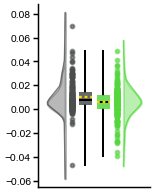

In [30]:
fig_name = f'{SUBJECT_TYPE}-sttc-ALL-homeo_units'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.15, 1.4))
    op_dz = main_ubudf_hom.loc[main_ubudf_hom['probe'] == 'optrode']['dz'].to_numpy()
    cr_dz = main_ubudf_hom.loc[main_ubudf_hom['probe'] == 'contra']['dz'].to_numpy()

    op_mean = np.mean(op_dz)
    cr_mean = np.mean(cr_dz)
    op_std = np.std(op_dz)
    cr_std = np.std(cr_dz)

    #plot the mean as a point with std error bars
    acr.plots.add_boxplot(ax, data=cr_dz, positions=[0.46], color=NNXR_GRAY)
    acr.plots.add_boxplot(ax, data=op_dz, positions=[0.54], color=MAIN_COLOR)
    acr.plots.add_data_points(ax, data=cr_dz, x_pos=0.4, color=NNXR_GRAY, s=30, alpha=0.6)
    acr.plots.add_data_points(ax, data=op_dz, x_pos=0.6, color=MAIN_COLOR, s=30, alpha=0.6)
    
    # add kde-style density plot for cr_dz at x=0.35
    acr.plots.add_vertical_kde(ax, data=cr_dz, x_pos=0.37, color=NNXR_GRAY, width=0.08, alpha=0.4)
    # add kde-style density plot for op_dz at x=0.65
    acr.plots.add_vertical_kde(ax, data=op_dz, x_pos=0.63, color=MAIN_COLOR, width=0.08, alpha=0.4, flip=True)

    ax.set_xlim(0.25, 0.75)
    #ax.set_ylim(-.07, 0.19)
    ax.set_xticklabels([])
    #ax.set_yticklabels([])
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

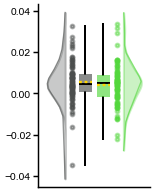

In [31]:
fig_name = f'{SUBJECT_TYPE}-sttc-ALL-FIX_units'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.15, 1.4))
    op_dz = main_ubudf_fix.loc[main_ubudf_fix['probe'] == 'optrode']['dz'].to_numpy()
    cr_dz = main_ubudf_fix.loc[main_ubudf_fix['probe'] == 'contra']['dz'].to_numpy()

    op_mean = np.mean(op_dz)
    cr_mean = np.mean(cr_dz)
    op_std = np.std(op_dz)
    cr_std = np.std(cr_dz)

    #plot the mean as a point with std error bars
    acr.plots.add_boxplot(ax, data=cr_dz, positions=[0.46], color=NNXR_GRAY, alpha=0.65)
    acr.plots.add_boxplot(ax, data=op_dz, positions=[0.54], color=MAIN_COLOR, alpha=0.65)
    acr.plots.add_data_points(ax, data=cr_dz, x_pos=0.4, color=NNXR_GRAY, s=30, alpha=0.45)
    acr.plots.add_data_points(ax, data=op_dz, x_pos=0.6, color=MAIN_COLOR, s=30, alpha=0.45)
    
    # add kde-style density plot for cr_dz at x=0.35
    acr.plots.add_vertical_kde(ax, data=cr_dz, x_pos=0.37, color=NNXR_GRAY, width=0.08, alpha=0.3)
    # add kde-style density plot for op_dz at x=0.65
    acr.plots.add_vertical_kde(ax, data=op_dz, x_pos=0.63, color=MAIN_COLOR, width=0.08, alpha=0.3, flip=True)

    ax.set_xlim(0.25, 0.75)
    #ax.set_ylim(-.07, 0.19)
    ax.set_xticklabels([])
    #ax.set_yticklabels([])
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')